# 4.5 IIR filters and difference equations

## 4.5.1 Applying a filter to data stored in a file

In the Python or MATLB environment, you can carry out many filter applications,  
but those applications do not happen in real time  
Let's first look at how we may apply a filter using Python,  
but then we will learn how to put a filter on an Arduino using difference equations,  
so it can operate in the lab, in real time  
  
So, before we learn how to write difference equations,  
let's apply a filter to a signal using Python  
In python, you can test a discrete time filter using the dlti object and the output method  
  
The code cell below, creates a signal with noise for testing  

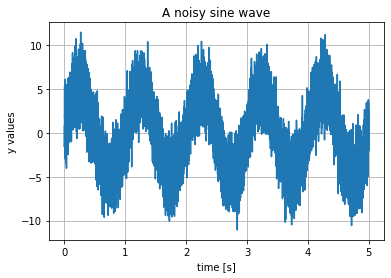

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# create a sine wave signal sampled at 2000 samples/sec
# this will be considered a continuous time signal because the sampling rate is high  
# compared to the filter
t = np.linspace(0, 5, 10000)

# 1 Hz sine wave with amplitude of 5
A = -5j
s = 1j*2*np.pi*1
x_clean_t = (A/2)*np.exp(s*t)+(np.conjugate(A)/2)*np.exp(np.conjugate(s)*t)

# create noise 
x_noise_t = np.random.normal(0, 2, 10000)

# create a noisy input signal 
x_t = (x_clean_t + x_noise_t).real

plt.plot(t, x_t)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('A noisy sine wave')
plt.grid()

In the lab, a signal such as the one above could be recorded into a file  
Then Python could be used to filter the data stored in the file  
We will simply apply our filter to the data above using the output method  
[Output method of the dlti object](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.dlsim.html#scipy.signal.dlsim)
  
The filter we will test is a zero-order hold model of  
$H(s)=\frac{10}{s+10}$ with a sampling rate of 20 samples/sec  
This is a simple first-order low-pass filter  
with a gain of 1 and a cut-off frequency of 10[rad/s]  
  
It's fine that the input data is sampled faster than the filter's sampling rate  
The filter is ignoring the data between samples  
Notice the time array and the output array produced by the method,  
only have 101 points rather than 10000

length of input arrays = 10000 10000
length of output arrays = 101 101


C:\Apps-SU\Anaconda\lib\site-packages\scipy\signal\filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


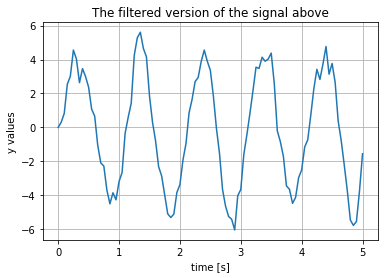

In [2]:
import scipy.signal as sig

num = [10]
den = [1, 10]
H_s = sig.lti(num, den)

dt = 0.05
H_z = H_s.to_discrete(dt=dt, method='zoh')

t_out, y_t = H_z.output(x_t, t=t)
print('length of input arrays =', len(t), len(x_t))
print('length of output arrays =', len(t_out), len(y_t))

plt.plot(t_out, y_t)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('The filtered version of the signal above')
plt.grid()

So the filter did a pretty good job removing the noise we added,  
but now let's learn how to implement this filter on an Arduino,  
so you can feed any signal generated in the lab into the filter and see the result in real time  

## 4.5.2 A simple real-time digital signal processing system

The math we just did above is often called digital signal processing, or DSP  
But implementing these filters on real hardware requires learning how a DSP processor works  
For our simple filters, we can utilize an Arduino as a DSP processor  
Most Arduino development boards are very slow for any effective DSP processing, however,  
that is changing all the time.  Now Arduino development boards are running ARM M4 or even ARM M7  
processors with plenty of speed for many effective DSP applications  
  
A block diagram of the system we want to implement on a DSP processor is shown below  
![image1!](./images_s4/image_4_5_1.png)  
We understand that the zero-order hold of the ADC will have a slight impact on the transfer function  
However, in these filter applications, we typically only concern ourselves with $H(z)$,  
rather than the entire continuous time transfer function H(s)  
  
Inputs can be created by wave generators or sensors and outputs can be viewed on an oscilloscope screen  

## 4.5.3 Writing difference equations

The difference equation comes directly from the discrete time transfer function  
The cell below prints the transfer function for our filter just to remind us it's value  

In [3]:
print(H_z)

TransferFunctionDiscrete(
array([0.39346934]),
array([ 1.        , -0.60653066]),
dt: 0.05
)


Remember, the transfer function describes the output over the input  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{0.39}{z-0.61}$$  
The trick to writing difference equations is to express the transfer function in terms of time delays  
  
You need to find the highest order term of the polynomials in the transfer function  
For our transfer function, it is order 1, or $z$ to the first power  
  
This means we multiply the transfer function by $\frac{z^{-1}}{z^{-1}}$, which doesn't change anything because it is just 1  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{0.39z^{-1}}{1-0.61z^{-1}}$$  
Whenever you write the transfer function in this form, the first term of the denominator should always be 1  
  
The next step is to cross multiply with the input and output signals  
You will get the following  
  
$$Y(z)(1-0.61z^{-1})=X(z)(0.39z^{-1})$$  
Distribute the terms  
  
$$Y(z)-0.61Y(z)z^{-1}=0.39X(z)z^{-1}$$  
You can now interpret, $z^{-1}$ as a delay to the next sample  
Assume that $Y(z)$ represents the current sample,  
and $Y(z)z^{-1}$ represents the previous sample  
  
We will use subscript $k$ for the current sample and subscript $k-1$ for the previous sample  
Such that the difference equation becomes  
  
$$Y_k-0.61Y_{k-1}=0.39X_{k-1}$$  
Finally, solve for the current sample of the output, $Y_k$  
That is the output of the filter that is sent to the DAC  
  
$$Y_k=0.61Y_{k-1}+0.39X_{k-1}$$  
In the block diagram of the sampled system above,  
H(z) is implemented with this difference equation 

## 4.5.4 Testing the real-time digital filter

The code below is written in a form so you can see how to implement the filter  
on an Arduino development board, in real time  
The comments in the code are intended as part of the reading  
  
We showed the coefficients above with only 2 digits of precision, so it's easier to read  
You should use the coefficients reported by the transfer function with all digits of precision  

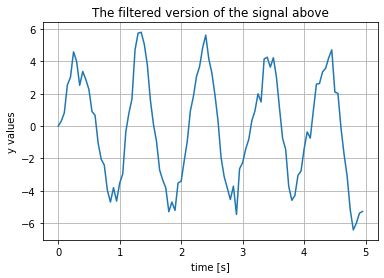

In [4]:
# change the previous input array so data
# is at the sampling rate, every one hundredth point
analogRead = x_t[::100]

# create a list to remember the output values
# this list would not be needed in Arduino because the data
# is produced in real time and does not need to be saved
analogWrite = []

# a real time filter does not store an array of numbers
# it only needs to store the previous values x[k-1] and y[k-1]
# we will use the variable names x_k1 and y_k1,
# but the variables must be initialized before we start the loop
x_k1 = 0
y_k1 = 0

# in Arduino the for loop below would be the statement
# void loop() {
# in Arduino the loop will run forever, because you don't want your filter to stop
for k in range(len(analogRead)):
    
    x_k = analogRead[k] # read the value from the ADC unit
    
    y_k = 0.60653066*y_k1 + 0.39346934*x_k1 # compute y_k from the difference equation
    
    # send the answer to the DAC to produce our countinuous time output
    # the DAC will have a slight impact on the transfer function
    # because of zero-order hold, but we are not accounting for that
    analogWrite.append(y_k) 
    
    # you must remember the current value
    # because it will become the previous value next time around the loop
    # this technique is called pipelining
    # our pipelines are only 1 element deep
    x_k1 = x_k
    y_k1 = y_k    
    
    # in Arduino, you would add a delay to set the sampling rate
    # delayMicroseconds(us) if your filter has a high sampling rate
    # our filter only samples at 20 samples/second, so use the millisecod delay
    # 20 samples/sec gives T = 50 milliseconds
    # delay(50)
    
# That's it, that's the entire code for the filter
plt.plot(t[::100], analogWrite)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('The filtered version of the signal above')
plt.grid()

## 4.5.5 Infinite impulse response

The acronym, IIR, stands for infinite impulse response  
You can easily recognize this type of response from the difference equation  
  
If the difference equation uses previous values of the output,  
in order to compute the current value of the output, the filter is IIR  
  
It simply means that an impulse input will contnue to generate output  
for all time as $t\rightarrow\infty$  
  
The unit impulse response can be found by taking the inverse z-transform of the transfer function  
consider our example  
  
$$\mathcal{Z}^{-1}\left\{H(z)\right\}=\mathcal{Z}^{-1}\left\{\left(\frac{0.39z}{z-0.61}\right)\left(z^{-1}\right)\right\}$$  
which is the time delayed exponential  
  
$$0.39(0.61^{k-1})=0.39e^{-10(k-1)T}\quad where\;T=0.05[s]\;and\;k\geq1$$  
An exponentially decaying function never reaches 0, it approaches 0 as $t\rightarrow\infty$

## 4.5.6 Creating a filter with Scipy

Python's Scipy library has several methods to create a continuous time or discrete time filters  
The methods return a transfer function  

For our next example, let's create a $3^{rd}$ order Butterworth filter  
[Butterworth filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter)  
  
We will create a $3^{rd}$ order Butterworth filter with the same  
sampling rate (20 samples/sec) and cut-off frequency (10[rad/s])  
as our previous first order example  
  
How the Scipy discrete time methods define a cut-off frequency is rather difficult to understand  
The method wants a value between 0 and 1, where 1 represents the Nyquist-Shannon sampling limit  
For a system sampled at 20 samples/sec, the Nyquist-Shannon limit is 10Hz (half the sampling rate)  
Converting to radians/second, $\omega=2\pi f=62.8[rad/s]$  
So a cut-off frequency of 10[rad/s] is represented by $\frac{10}{62.8}=0.159$  

The code cell below creates the filter  

In [5]:
num, den = sig.butter(3, 0.159)
print('num =', num)
print('den =', den)

num = [0.01001722 0.03005167 0.03005167 0.01001722]
den = [ 1.         -2.00992459  1.45421983 -0.36415745]


Just so we can be sure the filter is what we expect  
let's create a dlti object and plot the Bode plot  
  
The code cell below creates the Bode plot  

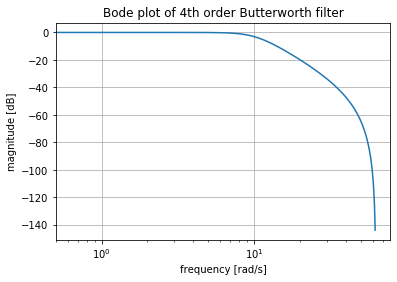

In [6]:
H_z = sig.dlti(num, den, dt=0.05)
w, mag, phase = H_z.bode()

plt.plot(w, mag)
plt.xscale('log')
plt.xlabel('frequency [rad/s]')
plt.ylabel('magnitude [dB]')
plt.title('Bode plot of 4th order Butterworth filter')
plt.grid()

You can see the cut-off frequency is indeed at 10[rad/s]  
you can also so the transfer function has at least one zero at $z=-1$  
from $z=e^{sT}$, $z=-1$ is at half the sampling rate, $s=j62.8$  

## 4.5.7 Implementing the Butterworth filter in real time

Before we can write the Arduino code for the filter, we must first write the difference equation  
The "butter" method returned the transfer function  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{0.01z^3+0.03z^2+0.03z+0.01}{z^3-2z^2+1.45z-0.36}$$  
The coefficients have been shortened, so it's easier to read  
You really need to use the coefficients in full precision in your code  
  
For DC frequecncies, $z=1$  
If you put $z=1$ into the transfer function, it will give you the DC gain  
From our Bode plot we are expecting a DC gain of 1  
  
To find the difference equation multiply by $\frac{z^{-3}}{z^{-3}}$  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{0.01+0.03z^{-1}+0.03z{-2}+0.01z^{-3}}{1-2z^{-1}+1.45z^{-2}-0.36z^{-3}}$$  
cross multiply  
  
$$Y(z)(1-2z^{-1}+1.45z^{-2}-0.36z^{-3})=X(z)(0.01+0.03z^{-1}+0.03z{-2}+0.01z^{-3})$$  
distribute the terms  
  
$$Y(z)-2Y(z)z^{-1}+1.45Y(z)z^{-2}-0.36Y(z)z^{-3}=0.01X(z)+0.03X(z)z^{-1}+0.03X(z)z{-2}+0.01X(z)z^{-3}$$  
interpret $z^{-1}$ as a time delay and solve for the current output  
  
$$Y_k=2Y_{k-1}-1.45Y_{k-2}+0.36Y_{k-3}+0.01X_k+0.03X_{k-1}+0.03X_{k-2}+0.01X_{k-3}$$  
The code cell below implements the filter  
some of the comments have been removed to make seeing the code easier  

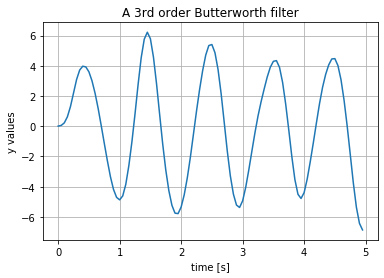

In [7]:
analogRead = x_t[::100]
analogWrite = []

x_k1 = 0
x_k2 = 0
x_k3 = 0
y_k1 = 0
y_k2 = 0
y_k3 = 0

for k in range(len(analogRead)):
    x_k = analogRead[k] # read the value from the ADC unit
    
    y_k = 2.00992459*y_k1 # you could write the entire equation on one line
    y_k = y_k - 1.45421983*y_k2 # or you could use +=
    y_k = y_k + 0.36415745*y_k3 # or you can leave it as is
    y_k = y_k + 0.01001722*x_k
    y_k = y_k + 0.03005167*x_k1
    y_k = y_k + 0.03005167*x_k2
    y_k = y_k + 0.01001722*x_k3

    analogWrite.append(y_k) 
    
    # our pipelines are 3 elements deep
    # and you must assign X_k3 and y_k3 first, the order matters
    x_k3 = x_k2
    x_k2 = x_k1
    x_k1 = x_k
    y_k3 = y_k2    
    y_k2 = y_k1    
    y_k1 = y_k    
    
    # delay(50)
    
plt.plot(t[::100], analogWrite)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('A 3rd order Butterworth filter')
plt.grid()